# Libraries installation

In [1]:
# !pip uninstall torch torchvision torchaudio -y
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# !pip install mne -q
# !pip install wandb -q
# !pip install tensorboard -q

# Constants and libraries

In [2]:
'''
In this section one defines environment variables. 
Because I used this notebook on number of machines, I implemented class especially for this. 
You may not needed in one and use just simple definitions.
'''

from system_variables import SystemVariables

# choose system according your current machine
# SYSTEM_NAME = "Windows"
# SYSTEM_NAME = "Colab"
# SYSTEM_NAME = "Kaggle"
SYSTEM_NAME = "Linux"

sv = SystemVariables(SYSTEM_NAME)
PROJECT_FOLDER = sv.get_project_folder()
SRC_FOLDER = sv.get_src_folder()
OUTPUT_FOLDER = sv.get_output_folder()
TUAB_DIRECTORY, TUAB_TRAIN, TUAB_EVAL = sv.get_TUAB_folders()
DEPR_ANON_DIRECTORY = sv.get_depr_anon_folder()
INHOUSE_DIRECTORY = sv.get_inhouse_folder()

print(SYSTEM_NAME)
print()

print(f"{PROJECT_FOLDER = }")
print(f"{SRC_FOLDER = }")
print(f"{OUTPUT_FOLDER = }")
print()

print(f"{TUAB_DIRECTORY = }")
print(f"{TUAB_TRAIN = }")
print(f"{TUAB_EVAL = }")
print()

print(f"{DEPR_ANON_DIRECTORY = }")
print()

print(f"{INHOUSE_DIRECTORY = }")
print()

Linux

PROJECT_FOLDER = ''
SRC_FOLDER = ''
OUTPUT_FOLDER = ''

TUAB_DIRECTORY = 'Data/TUAB/'
TUAB_TRAIN = 'Data/TUAB/train/normal/01_tcp_ar/'
TUAB_EVAL = 'Data/TUAB/eval/normal/01_tcp_ar/'

DEPR_ANON_DIRECTORY = 'Data/depression_anonymized/'

INHOUSE_DIRECTORY = 'Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/'



In [3]:
import warnings
warnings.simplefilter("ignore")

import os
import sys
import pickle
import json
import random
from IPython.display import display, clear_output
import traceback

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

from tqdm.auto import tqdm as tqdm_auto

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import wandb
!wandb login 1b8e8dc9dcf1a34397a04197c4826d3fe7441dae

import mne

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
cpu


In [4]:
sys.path.append(SRC_FOLDER)

%load_ext autoreload
%autoreload 1
%aimport utils

from utils import SEED
from utils.common import objectName, seed_all, printLog, upd, Config
from utils.models_evaluation import evaluateClassifier, evaluateRegressor, evaluateClassifier_inner_outer_cv
from utils.data_reading import DataReader
from utils.plotting import dataset_hists, plotData, dict_to_df, printDatasetMeta, printDataloaderMeta, plotSamplesFromDataset
from utils.dataset import InMemoryDataset
from utils.logger import Logger
from utils.parser import parse_ml_config
from utils.early_stopper import EarlyStopper

from models import get_model, load_weights_from_wandb

from training import train_eval

# Train function

In [5]:
def train(config, verbose=0):
    try:
        if config["log_path"] is not None: logfile = open(os.path.join(config["log_path"], config["model"]["model_description"].replace(" ", "_").replace("/", ".")), "a")
        else: logfile = None
        
        #Data reading
        if verbose - 1 > 0: printLog("Data reading", logfile=logfile)
        if config["dataset"]["train"] == config["dataset"]["val"] == config["dataset"]["test"]:
            reader = DataReader(
                config["dataset"]["train"]["file"], 
                dataset_type=config["dataset"]["train"]["name"],
                verbose=(verbose-1)
            )
            train_set, val_set, test_set = reader.split(
                train_size=config["dataset"]["train"]["size"], val_size=config["dataset"]["val_size"], test_size=config["dataset"]["test_size"]
            )    
            
        elif config["dataset"]["val"] == config["dataset"]["test"]:
            train_reader = DataReader(
                config["dataset"]["train"]["file"],
                dataset_type=config["dataset"]["train"]["name"],
                verbose=(verbose-1),
            )
            train_set, _, _ = train_reader.split(
                train_size=config["dataset"]["train"]["size"], val_size=0, test_size=0
            )

            val_test_reader = DataReader(
                config["dataset"]["test"]["file"],
                dataset_type=config["dataset"]["test"]["name"],
                verbose=(verbose-1),
            )
            _, val_set, test_set = val_test_reader.split(
                train_size=0, val_size=config["dataset"]["val"]["size"], test_size=config["dataset"]["test"]["size"]
            )
            
        else:
            raise NotImplementedError("Unsupported datasets configuration")

        chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
        targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]

        #TODO: add to upd function ability to add new fields
        config["dataset"] = upd(config["dataset"], {
            "samples_shape": chunks_train[0].shape,
            "train": {"n_samples": len(chunks_train)},
            "val": {"n_samples": len(chunks_val)},
            "test": {"n_samples": len(chunks_test)},
        })
    
        train_dataset = InMemoryDataset(
            chunks_train, is_squeeze=config["dataset"]["train"]["is_squeeze"], is_unsqueeze=config["dataset"]["train"]["is_unsqueeze"], t_max=config["dataset"]["train"]["t_max"]
        )
        val_dataset = InMemoryDataset(
            chunks_val, is_squeeze=config["dataset"]["val"]["is_squeeze"], is_unsqueeze=config["dataset"]["val"]["is_unsqueeze"], t_max=config["dataset"]["val"]["t_max"]
        )
        test_dataset = InMemoryDataset(
            chunks_test, is_squeeze=config["dataset"]["test"]["is_squeeze"], is_unsqueeze=config["dataset"]["test"]["is_unsqueeze"], t_max=config["dataset"]["test"]["t_max"]
        )
    
        if verbose - 2 > 0: 
            printDatasetMeta(train_dataset, val_dataset, test_dataset)
            plotSamplesFromDataset(train_dataset)
    
        #Dataloader
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
        val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
        test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
    
        if verbose - 2 > 0: printDataloaderMeta(train_dataloader, val_dataloader, test_dataloader)
    
        #Model
        config["model"].update({
            "input_dim" : train_dataset[0].shape,
        })
        model, config["model"] = get_model(config["model"])
        model = model.to(device)
        if verbose - 1 > 0: printLog('model ' + config["model"]['model_description'] + ' is created', logfile=logfile)
    
        #Download weights
        if "artifact" in config["model"] and "file" in config["model"]:
            model = load_weights_from_wandb(model, config["model"]["artifact"], config["model"]["file"], verbose=verbose)
    
        # TESTS
        model.eval()
        test_data_point = train_dataset[0][None].to(device)
        inference_result = model(test_data_point)
        reconstruct_result = model.reconstruct(test_data_point)
        encode_result = model.encode(test_data_point)
        if verbose - 1 > 0: 
            printLog(f"Test data point shape: {test_data_point.shape}", logfile=logfile)
            printLog(f"Test inference result length: {len(inference_result)}", logfile=logfile)
            printLog(f"Test reconstruct shape: {reconstruct_result.shape}", logfile=logfile)
            printLog(f"Test encode shape: {encode_result.shape}", logfile=logfile)
    
        #optimizer and scheduler
        optimizer = getattr(torch.optim, config["optimizer"]["optimizer"])(model.parameters(), **config["optimizer"]["kwargs"])
        if verbose - 1 > 0: printLog(f'Optimizer {type(optimizer).__name__} is instantiated', logfile=logfile)
    
        scheduler = getattr(torch.optim.lr_scheduler, config["scheduler"]["scheduler"])(optimizer, **config["scheduler"]["kwargs"])
        if verbose - 1 > 0: printLog(f'Scheduler {type(scheduler).__name__} is instantiated', logfile=logfile)
    
        logger = Logger(
            log_type=config["logger"]["log_type"], 
            run_name=config["model"]["model_description"],
            save_path=config["save_path"],
            model=model,
            model_name=config["model"]["model"],        
            project_name=config["project_name"],
            config=config,
            model_description=config["model"]["model_description"],
        #         log_dir = OUTPUT_FOLDER + "logs/"
        )

        #print whole config
        printLog('#################### ' + config["model"]["model_description"] + ' ####################', logfile=logfile)
        printLog(json.dumps(config, indent=4), logfile=logfile)
        
        #parse ml config
        #should be just before training because replace names by objects
        config["ml"] = parse_ml_config(config["ml"])
    
        #seed
        seed_all(SEED)
    
        #training
        # best_loss = np.inf
        best_clf_accuracy = -np.inf
        best_model = None
        best_epoch = None
        final_model = None
        early_stopper = EarlyStopper(**config['train']['early_stopping'])
        
        for epoch in tqdm_auto(range(config["train"]['start_epoch'], config["train"]['end_epoch'])):
            if verbose > 0: printLog(f"Epoch {epoch}", logfile=logfile)
            
            #######
            # train
            #######
            if verbose > 0: printLog("##### Training... #####", logfile=logfile)
            model, results = train_eval(
                train_dataloader,
                model,
                device=device,
                mode="train",
                optimizer=optimizer,
                epoch=epoch,
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                is_mask=(config["train"]["masking"]["n_masks"] != 0 and config["train"]["masking"]["mask_ratio"] != 0),
                mask_ratio=config["train"]["masking"]["mask_ratio"],
                step_max=config["train"]["step_max"], 
                verbose=verbose,
            )
            if results == {}: break
            if verbose > 0: 
                display(dict_to_df(results))
                for k in results: 
                    if isinstance(results[k], np.ndarray): results[k] = float(results[k].tolist())
                print(json.dumps(results, indent=4), file=logfile)
    
            ############
            # validation
            ############
            if verbose > 0: printLog("##### Validation... #####", logfile=logfile)
            model, results = train_eval(
                val_dataloader,
                model,
                device=device,
                mode="validation",
                test_dataset=val_dataset,
                targets_test=targets_val,
                check_period=config["train"]["validation"]["check_period"] if epoch % config['train']['validation']['check_period_per_epoch'] == 0 else None,
                plot_period=config["train"]["validation"]["plot_period"] if epoch % config['train']['validation']['plot_period_per_epoch'] == 0 else None,
                epoch=epoch,
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                step_max=config["train"]["step_max"], 
                verbose=verbose,
                **config["ml"],
            )
            if results == {}: break
            if verbose > 0: 
                display(dict_to_df(results))
                for k in results: 
                    if type(results[k]) == np.ndarray: results[k] = float(results[k].tolist())
                print(json.dumps(results, indent=4), file=logfile)
    
            scheduler.step(results['loss'])
            logger.save_model(epoch)
            final_model = model
    
            zero_ml_tag = config["ml"]["ml_eval_function_tag"][0]
            last_tag = "cv" if zero_ml_tag == "cv" else "bs"
            if results.get(f'clf.{zero_ml_tag}.test.accuracy.{last_tag}', -1) >= best_clf_accuracy:
                best_clf_accuracy = results[f'clf.{zero_ml_tag}.test.accuracy.{last_tag}']
                best_model = model
                best_epoch = best_epoch
                if verbose > 0: printLog(f"New best classifier accuracy = {best_clf_accuracy} on epoch {epoch}", logfile=logfile)
            
            # if results['loss'] < best_loss:
            #     best_loss = results['loss']
            #     best_model = model
            #     best_epoch = best_epoch
            #     if verbose > 0: printLog(f"New best loss = {best_loss} on epoch {epoch}", logfile=logfile)
            
            if early_stopper.early_stop(results['loss']): break
    
        logger.save_model(config["train"]['end_epoch'])
    
        ######
        # test
        ######
        results_all = {}
        for model, mode in zip([final_model, best_model], ["final", "test"]):
            if verbose > 0: printLog(f"##### Testing in {mode} mode... #####", logfile=logfile)
            _, results = train_eval(
                test_dataloader,
                model,
                device=device,
                mode=mode,
                test_dataset=test_dataset,
                targets_test=targets_test,
                check_period=1e10,
                plot_period=1e10,
                epoch=config["train"]['end_epoch'],
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                step_max=config["train"]["step_max"], 
                verbose=verbose,
                **config["ml"],
            )
            results_all[mode] = results
            if verbose > 0: 
                display(dict_to_df(results))
                for k in results: 
                    if type(results[k]) == np.ndarray: results[k] = float(results[k].tolist())
                print(json.dumps(results, indent=4), file=logfile)
        
        logger.update_summary("validation.best_epoch", best_epoch)
        logger.finish()

        logfile.close()
        return results_all
        
    except Exception as error:
        # handle the exception
        exc_type, exc_value, exc_traceback = sys.exc_info()
        traceback.print_exception(exc_type, exc_value, exc_traceback) 
        if logfile is not None: 
            traceback.print_exception(exc_type, exc_value, exc_traceback, file=logfile) 
            logfile.close()
        return {}

# Config

In [6]:
train_config = {
    "loss_coefs": {
        "ampl": 1,
        "vel": 0,
        "acc": 0,
        "frq": 0,
        "kl": 1
    },
    "masking" :{
        "n_masks" : 0, #0/1
        "mask_ratio" : 0 #[0, 1]
    },
    
    "start_epoch": 0, # including
    "end_epoch": 1, # excluding,
    "step_max" : 1, #None,

    "early_stopping": {
        "patience": 10,
        "eps": 1e-8
    },
    
    "validation": {
        "check_period": 1e10,
        "plot_period": None, #1e10
        "check_period_per_epoch": 5,
        "plot_period_per_epoch": 5
    }
}

logger_config = {
    "log_type" : "none", #"wandb"/"tensorboard"/"none"
}

model_config = {
    "model": "VAE_deep",
    "loss_reduction" : "mean",
    "model_description": "beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid",
    "latent_dim":32*16*1,
    "first_decoder_conv_depth": 32,
    # "artifact" : 'dmitriykornilov_team/EEG_age_prediction/AE:v18',
    # "file": '50_epoch.pth'
}

dataset_config = {
    "batch_size": 256,
    "num_workers": 0,
    "samples_shape": None, #will be updated in train function
    "train": {
        "name": "inhouse_dataset", #inhouse_dataset/depression_anonymized/TUAB
        "file": INHOUSE_DIRECTORY + "dataset_128_1.0.pkl", #TUAB_DIRECTORY + "dataset_128_1.0.pkl",
        "size": None,
        "n_samples": None, #will be updated in train function,
        "is_squeeze": False,
        "is_unsqueeze": False,
        "t_max": None,
    },
    "val": {
        "name": "inhouse_dataset", #inhouse_dataset/depression_anonymized/TUAB
        "file": INHOUSE_DIRECTORY + "dataset_128_1.0.pkl",
        "size": 30, #n_patients
        "n_samples": None, #will be updated in train function
        "is_squeeze": False,
        "is_unsqueeze": False,
        "t_max": None,
    },
    "test": {
        "name": "inhouse_dataset", #inhouse_dataset/depression_anonymized/TUAB
        "file": INHOUSE_DIRECTORY + "dataset_128_1.0.pkl",
        "size": 30, #n_patients
        "n_samples": None, #will be updated in train function
        "is_squeeze": False,
        "is_unsqueeze": False,
        "t_max": None,
    },
    
}

optimizer_config = {
    "optimizer" : "AdamW",
    "kwargs": {
        "lr": 1e-3
    }
}

scheduler_config = {
    "scheduler" : "ReduceLROnPlateau",
    "kwargs": {
        "factor": 0.5,
        "patience": 3, 
        "verbose": True
    }
}

ml_config = {
    "avg_embeddings_over_time": True,
    "plot_type": "classification", #"regression"/"classification"
    "ml_model": {
        "scaler" : "preprocessing.StandardScaler",
        "clf": "svm.SVC",
    },
    "ml_param_grid" : {
        'clf__kernel': ['linear'],
        'clf__C': list(np.logspace(-1, 1, 3)),
        'clf__probability': [True],
        'clf__class_weight': ['balanced'],
        'clf__random_state': [SEED]
    },
    "ml_eval_function" : [
        # "evaluateClassifier_inner_outer_cv",
        "evaluateClassifier", 
    ],
    "ml_eval_function_tag" : [
        # "cv", 
        "d"
    ],
    "ml_eval_function_kwargs" : [
        # {
        #     "verbose" : 0,
        #     "SEED" : SEED,
        #     "cv_scorer" : "accuracy_score",
        #     "metrics" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
        #     "n_splits_inner" : 5,
        #     "n_splits_outer" : 10,
        # },
        {
            "verbose" : 0,
            "test_size" : 0.33,
            "SEED" : SEED,
            "cv_scorer" : "accuracy_score",
            "metrics" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            "metrics_for_CI": [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            "n_bootstraps" : 1000
        },
    ],
    "ml_metric_prefix" : "clf",
    
    # ml_model=Pipeline([('scaler', StandardScaler()), ('reg', Ridge())]),
    # ml_param_grid={
    #     'reg__alpha': np.logspace(-2, 2, 5),
    #     # 'reg__solver': ['sag'],
    #     # 'reg__tol': [1e-4]
    # },
    # ml_eval_function=evaluateRegressor,
    # ml_metric_names=["mse_test", "mse_train"],
    # ml_metric_prefix="reg",
}


default_config = {
    "project_name": 'EEG_depression_classification',
    "method": "direct restoration",
    "save_path" : OUTPUT_FOLDER + 'model_weights/',
    "log_path" : OUTPUT_FOLDER + "logs/",
    
    "dataset": dataset_config,
    "model": model_config,
    "optimizer" : optimizer_config,
    "scheduler": scheduler_config,
    "train": train_config,
    "ml": ml_config,
    "logger": logger_config,
}

# print("Config:", json.dumps(default_config, indent=4))

# Experiments

In [7]:
import itertools

experiments = []

#duration
current_config = Config(default_config)
dc = Config(default_config)
for t in [
    1#, 2, 4, 5, 10, 15, 30, 60
]:
    dataset_name = "inhouse_dataset"
    dataset = {}
    dataset['name'] = dataset_name
    dataset['file'] = INHOUSE_DIRECTORY + f"dataset_128_{t}.0.pkl"
    experiments.append(current_config.upd({
        "dataset" : {
            "train": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": None,
            },
            "val": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": 30,
            },
            "test": {
                "name": dataset['name'], #inhouse_dataset/depression_anonymized/TUAB
                "file": dataset['file'],
                "size": 30,
            },
        },
        "model": {
            "model_description": "test", #f"duration, {dataset_name}, {t} s, " + dc.config['model']['model_description'],
            "latent_dim":32*16*t,
            "first_decoder_conv_depth": 32,
        },
    }))

In [8]:
print("N experiments:", len(experiments))
for exp in experiments:
    print(exp['model']['model_description'])

N experiments: 1
test


# Training

Data reading

Chunks shape: (3, 128) , length: 14277 , keys: dict_keys(['chunk', 'target', 'patient'])
N patients = 149
Train=149, validation=0, test=0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14277/14277 [00:00<00:00, 21376.46it/s]


Train: 14277 (3, 128)

Chunks shape: (3, 128) , length: 14277 , keys: dict_keys(['chunk', 'target', 'patient'])
N patients = 149
Train=0, validation=74, test=75


  0%|                                                                                                                                                                                                     | 0/14277 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████▎                                                                                                                              | 4397/14277 [00:00<00:00, 22013.36it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 8726/14277 [00:00<00:00, 20482.02it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 12974/14277 [00:00<00:00, 20701.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14277/14277 [00:00<00:00, 20922.21it/s]

Validation: 6951 (3, 128)
Test: 7326 (3, 128)
Train dataset: 14277
Val dataset: 6951
Test dataset: 7326
Train sample shape: torch.Size([3, 128])
Val sample shape: torch.Size([3, 128])
Test sample shape: torch.Size([3, 128])
Train sample type: torch.FloatTensor
Val sample type: torch.FloatTensor
Test sample type: torch.FloatTensor


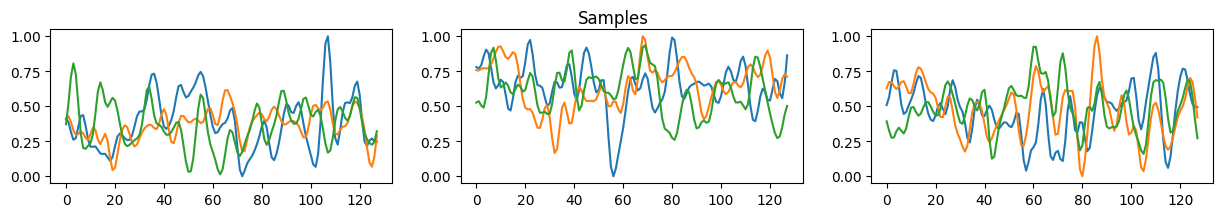

Train dataloader: 56
Val dataloader: 28
Test dataloader: 29
model test is created
Test data point shape: torch.Size([1, 3, 128])
Test inference result length: 4
Test reconstruct shape: torch.Size([1, 3, 128])
Test encode shape: torch.Size([1, 64, 16])
Optimizer AdamW is instantiated
Scheduler ReduceLROnPlateau is instantiated
No logging
#################### test ####################
{
    "project_name": "EEG_depression_classification",
    "method": "direct restoration",
    "save_path": "model_weights/",
    "log_path": "logs/",
    "dataset": {
        "batch_size": 256,
        "num_workers": 0,
        "samples_shape": [
            3,
            128
        ],
        "train": {
            "name": "inhouse_dataset",
            "file": "Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/dataset_128_1.0.pkl",
            "size": null,
            "n_samples": 14277,
            "is_squeeze": false,
            "is_unsqueeze": false,
           

  0%|                                                                                                                                                                                                         | 0/1 [00:00<?, ?it/s]

Epoch 0
##### Training... #####
Model is in train mode
Epoch time: 0.39011716842651367 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.457,0.543,0.016,0.200,0.457,0.007,0.004,0.011,0.676,0.457,0.901,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (6951, 64)
Evaluation time: 107.72992420196533 s
Epoch time: 108.06116986274719 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.444,0.556,-0.001,0.577,0.444,0.007,0.004,0.011,0.666,0.444,0.509,0.581,0.575,0.547,0.542,0.581,0.021,0.582,0.022,0.532,0.017,0.532,0.016,0.530,0.565,0.529,0.534,0.525,0.522,0.530,0.031,0.530,0.029,0.513,0.024,0.512,0.024,0.520,0.530


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.51s/it]

New best classifier accuracy = 0.5128001572592298 on epoch 0
##### Testing in final mode... #####
Model is in evaluation mode
Epoch 1, step 0
Plotting PCA...


,Explained variance,Ratio
0,6.227487e-08,9.999999e-01
1,2.089027e-15,3.354525e-08


Plotting reconstruction...


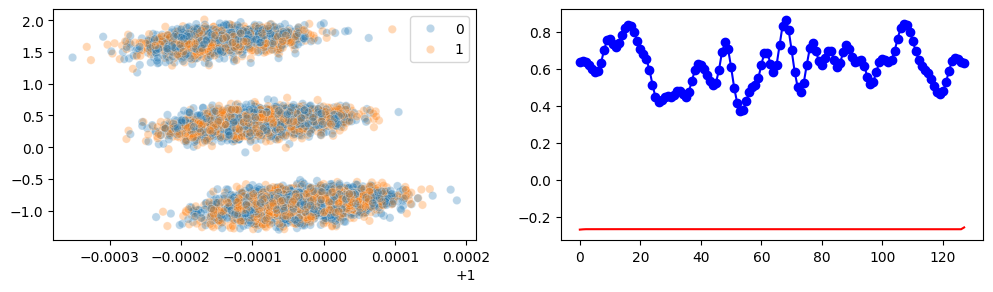

Plotting time: 1.2517547607421875 s
Classifier/regressor metrics evaluation...
Embeddings shape: (7326, 64)


In [ ]:
all_results = []
for config in experiments:
    exp_results = {
        config['model']["model_description"] : train(config, verbose=3)
    }
    all_results.append(exp_results)
    with open(os.path.join(config["log_path"], "all_results_" + config["model"]["model_description"].replace(" ", "_").replace("/", ".")), "w") as f:
        json.dump(exp_results, f, indent=4, ensure_ascii=False)
    with open("current_results.json", "w") as f:
        json.dump(all_results, f, indent=4, ensure_ascii=False)